In [42]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score


In [43]:
os.chdir('C:\\Users\\grace\\UNSW\\COMP4121\\COMP4121_MajorProject\\Data')

In [44]:
#Load datasets
raw_sales_df = pd.read_csv('raw_sales.csv', parse_dates=['datesold'])
ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])

C:\Users\grace\AppData\Local\Temp\ipykernel_22744\3741783504.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])


In [45]:
#Original data frames preview
print(raw_sales_df.head(5))
print(ma_lga_df.head(5))

    datesold  postcode   price propertyType  bedrooms
0 2007-02-07      2607  525000        house         4
1 2007-02-27      2906  290000        house         3
2 2007-03-07      2905  328000        house         3
3 2007-03-09      2905  380000        house         4
4 2007-03-21      2906  310000        house         3
    saledate      MA   type  bedrooms
0 2007-09-30  441854  house         2
1 2007-12-31  441854  house         2
2 2008-03-31  441854  house         2
3 2008-06-30  441854  house         2
4 2008-09-30  451583  house         2


In [46]:
# Step 1: Add year_quarter column to raw_sales_df and convert datesold to datetime
raw_sales_df['datesold'] = pd.to_datetime(raw_sales_df['datesold'])
raw_sales_df['year_quarter'] = raw_sales_df['datesold'].dt.year.astype(str) + '_Q' + raw_sales_df['datesold'].dt.quarter.astype(str)

# Step 2: Add year_quarter column to ma_lga_df and convert saledate to datetime
ma_lga_df['saledate'] = pd.to_datetime(ma_lga_df['saledate'])
ma_lga_df['year_quarter'] = ma_lga_df['saledate'].dt.year.astype(str) + '_Q' + ma_lga_df['saledate'].dt.quarter.astype(str)

In [47]:
# Step 3: Merge the dataframes on 'year_quarter', 'bedrooms', and 'type'
merged_df = pd.merge(
    raw_sales_df, 
    ma_lga_df[['year_quarter', 'type', 'bedrooms', 'MA']],  # Only the necessary columns from ma_lga_df
    how='left',  # Perform a left join to keep all rows from raw_sales_df
    left_on=['year_quarter', 'propertyType', 'bedrooms'],  # Merging keys
    right_on=['year_quarter', 'type', 'bedrooms']  # Merging keys in ma_lga_df
)

# Step 4: Rename columns to match raw_sales_df column names
merged_df = merged_df.rename(columns={
    'propertyType': 'property_type',  # Rename 'propertyType' to 'property_type'
    'datesold': 'date_sold'          # Rename 'datesold' to 'date_sold         # Fix duplicate column issue after merge
})

# Step 5: Drop 'property_type' column (duplicate after renaming)
merged_df['MA'] = merged_df['MA'].apply(lambda x: '{:.0f}'.format(x))
merged_df = merged_df.drop(columns=['type'])

# Step 6: Drop data entries with bedrooms = 0, since there are only 30 entries
merged_df = merged_df[merged_df['bedrooms'] != 0]

In [48]:
#import pandas as pd

# Assuming 'merged_df' is your DataFrame and 'date_sold' is the column with the sale dates

# Convert 'date_sold' to datetime if it's not already in datetime format
merged_df['date_sold'] = pd.to_datetime(merged_df['date_sold'])

# Sort by 'date_sold' to ensure data is in chronological order
merged_df = merged_df.sort_values(by='date_sold')

# Calculate the cutoff index for the 80-20 split
train_size = int(0.8 * len(merged_df))

# The cutoff date is the date of the observation at the 80% mark
cutoff_date = merged_df.iloc[train_size]['date_sold']
print(f"Cutoff Date for Test Set: {cutoff_date}")

# Split the data into train and test sets based on the cutoff date
train_df = merged_df[merged_df['date_sold'] < cutoff_date]
test_df = merged_df[merged_df['date_sold'] >= cutoff_date]

# Calculate 'normalized_price' and 'MA' on the training set only
train_df['normalized_price'] = train_df.groupby('year_quarter')['price'].transform(lambda x: x / x.median())
train_df['MA'] = train_df.groupby('year_quarter')['price'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

# Apply the same transformation to the test set based on the training data
test_df['normalized_price'] = test_df.groupby('year_quarter')['price'].transform(lambda x: x / train_df.groupby('year_quarter')['price'].median())
test_df['MA'] = test_df.groupby('year_quarter')['price'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())

# Now you have your train and test sets split by date and correctly calculated features


Cutoff Date for Test Set: 2017-11-15 00:00:00


C:\Users\grace\AppData\Local\Temp\ipykernel_22744\3130938711.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['normalized_price'] = train_df.groupby('year_quarter')['price'].transform(lambda x: x / x.median())
C:\Users\grace\AppData\Local\Temp\ipykernel_22744\3130938711.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['MA'] = train_df.groupby('year_quarter')['price'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
C:\Users\grace\AppData\Local\Temp\ipykernel_22744\313

Verify Train and Test is split correctly by dates before and after 2017

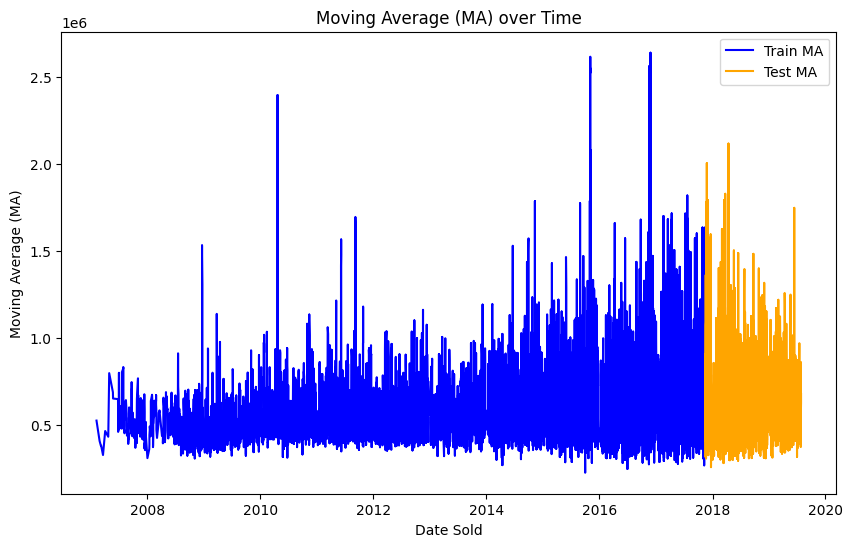

In [49]:
# Plot the MA over time for train and test data
plt.figure(figsize=(10, 6))

# Plot MA for train set
plt.plot(train_df['date_sold'], train_df['MA'], label='Train MA', color='blue')

# Plot MA for test set
plt.plot(test_df['date_sold'], test_df['MA'], label='Test MA', color='orange')

# Add labels and legend
plt.xlabel('Date Sold')
plt.ylabel('Moving Average (MA)')
plt.title('Moving Average (MA) over Time')
plt.legend()

plt.show()

Feature Engineering
- Mutated 'normalized_price'
    - Based on median price in a given year_sold x and bedroom y
        - 'normalized_price_median' = 'price' / 'median_price' 

Background
- Let the median price-based normalized price represent the price relative to the specific bedroom category and year.
- Let the MA-based normalized price represent the long-term market trend.

- A 'normalized_price' close to 1 represents a given property is close to a median or stable market price, greater than 1.2 represents price is 20% higher , etc.




In [50]:
#Step 1: Mutate 'year_sold'
train_df['year_sold'] = train_df['date_sold'].dt.year
train_df['month'] = train_df['date_sold'].dt.month

# Step 2: Group by year and number of bedrooms to calculate median price
median_price_by_bedrooms_year = train_df.groupby(['year_sold', 'bedrooms'])['price'].median().reset_index()
median_price_by_bedrooms_year.columns = ['year_sold', 'bedrooms', 'median_price']

# Step 3: convert 'median_price' and 'MA' to required float or int types
median_price_by_bedrooms_year['median_price'] = median_price_by_bedrooms_year['median_price'].astype('int64')
train_df['MA'] = pd.to_numeric(train_df['MA'], errors='coerce')

# Step 4: Merge 'merged_df' with 'median_price_by_bedrooms_year' on 'year_sold' and 'bedrooms'
train_df = pd.merge(train_df, median_price_by_bedrooms_year, on=['year_sold', 'bedrooms'], how='left')


#Step 1: Mutate 'year_sold'
test_df['year_sold'] = test_df['date_sold'].dt.year
test_df['month'] = test_df['date_sold'].dt.month

# Step 2: Group by year and number of bedrooms to calculate median price
median_price_by_bedrooms_year = test_df.groupby(['year_sold', 'bedrooms'])['price'].median().reset_index()
median_price_by_bedrooms_year.columns = ['year_sold', 'bedrooms', 'median_price']

# Step 3: convert 'median_price' and 'MA' to required float or int types
median_price_by_bedrooms_year['median_price'] = median_price_by_bedrooms_year['median_price'].astype('int64')
test_df['MA'] = pd.to_numeric(test_df['MA'], errors='coerce')

# Step 4: Merge 'merged_df' with 'median_price_by_bedrooms_year' on 'year_sold' and 'bedrooms'
test_df = pd.merge(test_df, median_price_by_bedrooms_year, on=['year_sold', 'bedrooms'], how='left')

C:\Users\grace\AppData\Local\Temp\ipykernel_22744\3603698873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['year_sold'] = train_df['date_sold'].dt.year
C:\Users\grace\AppData\Local\Temp\ipykernel_22744\3603698873.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['month'] = train_df['date_sold'].dt.month
C:\Users\grace\AppData\Local\Temp\ipykernel_22744\3603698873.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [51]:
train_df['normalized_price'] = train_df['price'] / train_df['median_price']
test_df['normalized_price'] = test_df['price'] / test_df['median_price']

print(merged_df.head(5))

   date_sold  postcode   price property_type  bedrooms year_quarter      MA
0 2007-02-07      2607  525000         house         4      2007_Q1  548969
1 2007-02-27      2906  290000         house         3      2007_Q1  421291
2 2007-03-07      2905  328000         house         3      2007_Q1  421291
3 2007-03-09      2905  380000         house         4      2007_Q1  548969
4 2007-03-21      2906  310000         house         3      2007_Q1  421291


In [52]:
train_df_prescaling = train_df[['date_sold', 'year_sold', 'price', 'bedrooms', 'year_quarter', 'MA', 'normalized_price']].dropna()
train_df = train_df[['date_sold', 'postcode', 'price', 'property_type', 'bedrooms', 'year_quarter', 'MA', 'normalized_price']].dropna()


Feature Engineering

- 'price_change'
- 'price_movement'
    - 0: Increasing (+1%)
    - 1: Decreasing (-1%)

In [53]:
train_df = train_df.sort_values(by=['year_quarter', 'bedrooms'])

# Calculate price change percentage by quarter
train_df['price_change'] = round(train_df.groupby(['year_quarter', 'bedrooms'])['price'].pct_change() * 100, 2)  # price_change in %

threshold = 1  # Define a threshold percentage (e.g., 1% increase or decrease)
train_df['price_movement'] = train_df['price_change'].apply(
    lambda x: 1 if x > threshold else (0 if x < -threshold else np.nan)
)
train_df = train_df.dropna(subset=['price_movement'])

In [54]:
train_df.sort_values(by='date_sold', ascending=False)

train_df.head(5)

,date_sold,postcode,price,property_type,bedrooms,year_quarter,MA,normalized_price,price_change,price_movement
2,2007-03-07,2905,328000,house,3,2007_Q1,381000.0,0.771765,13.10,1.0
4,2007-03-21,2906,310000,house,3,2007_Q1,327000.0,0.729412,-5.49,0.0
3,2007-03-09,2905,380000,house,4,2007_Q1,380750.0,0.681004,-27.62,0.0
8,2007-05-24,2902,359000,house,3,2007_Q2,688250.0,0.844706,-10.03,0.0
9,2007-05-25,2906,320000,house,3,2007_Q2,652000.0,0.752941,-10.86,0.0


In [55]:
train_df['year_quarter'] = train_df['year_quarter'].astype('category').cat.codes  # Encode 'propertyType' as numeric
train_df['normalized_price'] = train_df['normalized_price'].astype('category').cat.codes
train_df['property_type'] = train_df['property_type'].astype('category').cat.codes
train_df['postcode'] = train_df['postcode'].astype('category').cat.codes
train_df['price_movement'] = train_df['price_movement'].astype('category').cat.codes

In [56]:
train_df.head(5)

,date_sold,postcode,price,property_type,bedrooms,year_quarter,MA,normalized_price,price_change,price_movement
2,2007-03-07,21,328000,0,3,0,381000.0,1012,13.10,1
4,2007-03-21,22,310000,0,3,0,327000.0,652,-5.49,0
3,2007-03-09,21,380000,0,4,0,380750.0,356,-27.62,0
8,2007-05-24,18,359000,0,3,1,688250.0,1920,-10.03,0
9,2007-05-25,22,320000,0,3,1,652000.0,837,-10.86,0


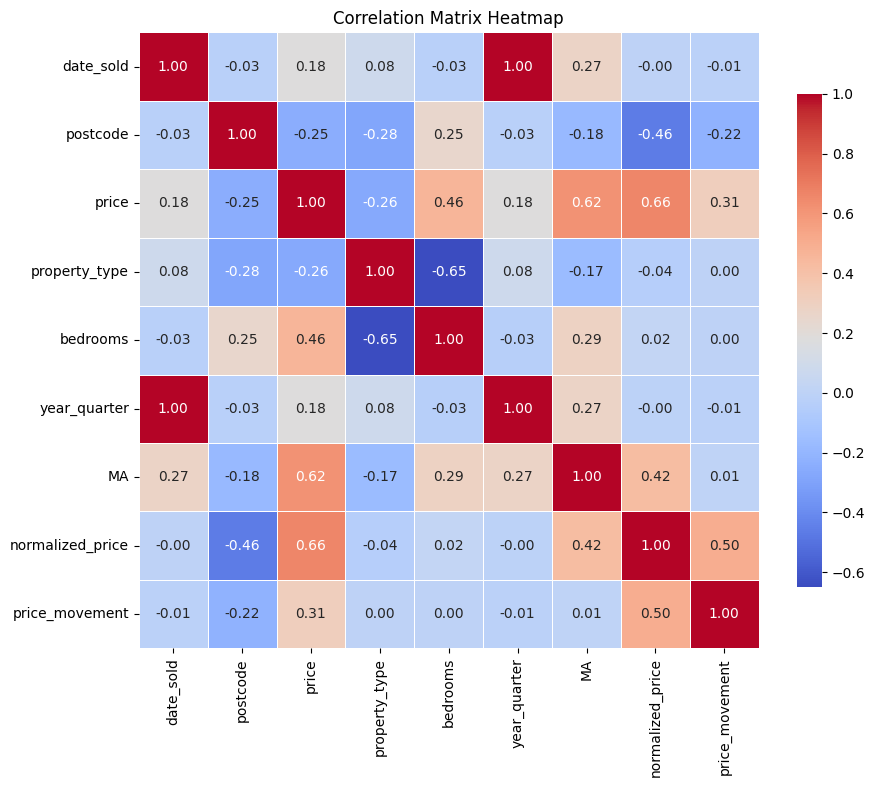

In [57]:
corr_matrix = train_df[['date_sold', 'postcode', 'price', 'property_type', 'bedrooms', 'year_quarter', 'MA', 'normalized_price', 'price_movement']].corr()

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create the heatmap with annotations and a color map (e.g., 'coolwarm')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': .8})

# Add a title
plt.title('Correlation Matrix Heatmap')

# Display the heatmap
plt.show()

In [ ]:
# Define the features (X) and target (y) for training and testing
train_df['price_movement'] = (train_df['price'].shift(-1) > train_df['price']).astype(int)
test_df['price_movement'] = (test_df['price'].shift(-1) > test_df['price']).astype(int) 

X_train = train_df[['normalized_price', 'MA', 'bedrooms']]  # Features for training
y_train = train_df['price_movement']  # Target for training

X_test = test_df[['normalized_price', 'MA', 'bedrooms']]  # Features for testing
y_test = test_df['price_movement']  # Target for testing

X_train = X_train.to_numpy()  # or X_train.values
X_test = X_test.to_numpy()  # or X_test.values

# Fit the scaler on the train and test data and transform it
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Verify correct length
print(len(X_train))
print(len(train_df))

3. Determine Optimal Number of Hidden States:
- Train HMM for multiple n states
- Evaluate Log-likelihood
- Use AIC/BIC for Model Selection

In [ ]:
#Step 3: Determine Optimal Number of Hidden States

#Iterate over different n states to find the optimal number
def find_optimal_states(features, max_states):
    aic_scores = []
    bic_scores = []
    models = []
    
    for n_states in range(2, max_states + 1):  # Test models with 2 to max_states
        hmm = GaussianHMM(n_components=n_states, random_state=42, n_iter=100)
        hmm.fit(features)
        models.append(hmm)
        
        # Calculate log likelihood
        log_likelihood = hmm.score(features)
        num_params = n_states**2 + 2 * n_states * features.shape[1] - 1 # Number of parameters
        
        # Calculate AIC and BIC
        aic = 2 * num_params - 2 * log_likelihood
        bic = np.log(len(features)) * num_params - 2 * log_likelihood
        
        aic_scores.append(aic)
        bic_scores.append(bic)
    
    # Find optimal number of states
    optimal_states_aic = 2 + np.argmin(aic_scores)
    optimal_states_bic = 2 + np.argmin(bic_scores)
    
    return optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models

#optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models = find_optimal_states(features=X_train_discretized, max_states=10)
optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models = find_optimal_states(features=X_train, max_states=10)

print(f"Optimal number of states based on AIC: {optimal_states_aic}")
print(f"Optimal number of states based on BIC: {optimal_states_bic}")

'#Step 3: Determine Optimal Number of Hidden States\n\n#Iterate over different n states to find the optimal number\ndef find_optimal_states(features, max_states):\n    aic_scores = []\n    bic_scores = []\n    models = []\n    \n    for n_states in range(2, max_states + 1):  # Test models with 2 to max_states\n        hmm = GaussianHMM(n_components=n_states, random_state=42, n_iter=100)\n        hmm.fit(features)\n        models.append(hmm)\n        \n        # Calculate log likelihood\n        log_likelihood = hmm.score(features)\n        num_params = n_states**2 + 2 * n_states * features.shape[1] - 1 # Number of parameters\n        \n        # Calculate AIC and BIC\n        aic = 2 * num_params - 2 * log_likelihood\n        bic = np.log(len(features)) * num_params - 2 * log_likelihood\n        \n        aic_scores.append(aic)\n        bic_scores.append(bic)\n    \n    # Find optimal number of states\n    optimal_states_aic = 2 + np.argmin(aic_scores)\n    optimal_states_bic = 2 + np.

In [ ]:
# Plot AIC and BIC
states_range = range(2, len(aic_scores) + 2)

plt.figure(figsize=(10, 6))
plt.plot(states_range, aic_scores, marker='o', label='AIC', color='blue')
plt.plot(states_range, bic_scores, marker='o', label='BIC', color='red')
plt.axvline(optimal_states_aic, color='blue', linestyle='--')
plt.axvline(optimal_states_bic, color='red', linestyle='--')
#plt.axvline(optimal_states_aic, color='blue', linestyle='--', label=f'Optimal States (AIC): {optimal_states_aic}')
#plt.axvline(optimal_states_bic, color='red', linestyle='--', label=f'Optimal States (BIC): {optimal_states_bic}')
plt.xlabel('Number of States')
plt.ylabel('Score')
plt.title('AIC and BIC for Hidden Markov Models')
plt.legend()
plt.show()

"# Plot AIC and BIC\nstates_range = range(2, len(aic_scores) + 2)\n\nplt.figure(figsize=(10, 6))\nplt.plot(states_range, aic_scores, marker='o', label='AIC', color='blue')\nplt.plot(states_range, bic_scores, marker='o', label='BIC', color='red')\nplt.axvline(optimal_states_aic, color='blue', linestyle='--')\nplt.axvline(optimal_states_bic, color='red', linestyle='--')\n#plt.axvline(optimal_states_aic, color='blue', linestyle='--', label=f'Optimal States (AIC): {optimal_states_aic}')\n#plt.axvline(optimal_states_bic, color='red', linestyle='--', label=f'Optimal States (BIC): {optimal_states_bic}')\nplt.xlabel('Number of States')\nplt.ylabel('Score')\nplt.title('AIC and BIC for Hidden Markov Models')\nplt.legend()\nplt.show()"

4. Train HMM with Optimal n States

- We found optimal n = 5

In [62]:
# Step 4: Train HMM on aggregated data
optimal_n = 5
hmm_model = GaussianHMM(n_components=optimal_n, n_iter=1000, random_state=42)  # 3 states: Decrease, Stable, Increase
hmm_model.fit(X_train)

GaussianHMM(n_components=5, n_iter=1000, random_state=42)

5. Predict Hidden States for Partitioning

In [63]:
# Predict the hidden states
hidden_states = hmm_model.predict(X_train)
hidden_states_test = hmm_model.predict(X_test)

# Create DataFrame with discretized features and hidden states
X_train_df = pd.DataFrame(X_train, columns=['normalized_price', 'MA', 'bedrooms'])
X_train_df['hidden_state'] = hidden_states

X_test_df = pd.DataFrame(X_test, columns=['normalized_price', 'MA', 'bedrooms'])
X_test_df['hidden_state'] = hidden_states_test

In [64]:
X_train_df['hidden_state'].unique()
X_train_df.head(5)

,normalized_price,MA,bedrooms,hidden_state
0,-1.381534,-1.204401,-0.312879,2
1,-1.523596,-1.503513,-0.312879,2
2,-1.640402,-1.205786,0.780078,1
3,-1.023222,0.497491,-0.312879,2
4,-1.450592,0.296698,-0.312879,2


6. Incorporate Hidden States into Classification
- Models:
    - Random Forest Classifier
    - Logistic Regression
    - SVM
    - K-Nearest Neighbor
    - Decision Tree
    - Gradient Boosting

In [65]:
# Check for missing values in the test data
print(X_test_df.isnull().sum())
X_test_df.head(5)

normalized_price    0
MA                  0
bedrooms            0
hidden_state        0
dtype: int64


,normalized_price,MA,bedrooms,hidden_state
0,-1.780490,0.894922,0.780078,2
1,-1.780568,0.036360,-0.312879,2
2,-1.780243,1.199573,0.780078,1
3,-1.780558,0.714901,-0.312879,2
4,-1.780549,0.323009,-0.312879,2


In [66]:
#Train Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
rf_predictions = rf.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- 1. Logistic Regression ---
logreg = LogisticRegression(random_state=42)
logreg.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
logreg_predictions = logreg.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- 2. Support Vector Machine (SVM) ---
svm = SVC(random_state=42)
svm.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
svm_predictions = svm.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- 3. K-Nearest Neighbors (KNN) ---
knn = KNeighborsClassifier()
knn.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
knn_predictions = knn.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- 4. Decision Tree ---
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
dtree_predictions = dtree.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])

# --- 5. Gradient Boosting ---
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
gbc_predictions = gbc.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])


In [67]:
# Random Forest Classifier Evaluation
print("Random Forest Classifier Performance:")
print(classification_report(y_test, rf_predictions))

# Logistic Regression Evaluation
print("Logistic Regression Performance:")
print(classification_report(y_test, logreg_predictions))

# Support Vector Machine Evaluation
print("Support Vector Machine Performance:")
print(classification_report(y_test, svm_predictions))

Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2998
           1       1.00      1.00      1.00      2933

    accuracy                           1.00      5931
   macro avg       1.00      1.00      1.00      5931
weighted avg       1.00      1.00      1.00      5931

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.68      0.64      0.66      2998
           1       0.66      0.69      0.67      2933

    accuracy                           0.67      5931
   macro avg       0.67      0.67      0.67      5931
weighted avg       0.67      0.67      0.67      5931

Support Vector Machine Performance:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      2998
           1       0.68      0.64      0.66      2933

    accuracy                           0.68      5931
   macro avg       0.

In [68]:
# K-Nearest Neighbors Evaluation
print("K-Nearest Neighbors Performance:")
print(classification_report(y_test, knn_predictions))

# Decision Tree Evaluation
print("Decision Tree Performance:")
print(classification_report(y_test, dtree_predictions))

# Gradient Boosting Evaluation
print("Gradient Boosting Performance:")
print(classification_report(y_test, gbc_predictions))

K-Nearest Neighbors Performance:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      2998
           1       0.74      0.73      0.74      2933

    accuracy                           0.74      5931
   macro avg       0.74      0.74      0.74      5931
weighted avg       0.74      0.74      0.74      5931

Decision Tree Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2998
           1       1.00      1.00      1.00      2933

    accuracy                           1.00      5931
   macro avg       1.00      1.00      1.00      5931
weighted avg       1.00      1.00      1.00      5931

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      2998
           1       0.73      0.70      0.72      2933

    accuracy                           0.72      5931
   macro avg       0.73      0.72    

Cross Validation Results

In [70]:
scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

cv_results_rf = cross_validate(rf, X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test, cv=5, scoring=scoring, return_train_score=True)
cv_results_dtree = cross_validate(dtree, X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test, cv=5, scoring=scoring, return_train_score=True)
cv_results_gbc = cross_validate(gbc, X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test, cv=5, scoring=scoring, return_train_score=True)
cv_results_knn = cross_validate(knn, X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test, cv=5, scoring=scoring, return_train_score=True)


'# Output the cross-validation results\nprint(f"Random Forest Test set accuracy scores: {cv_results_rf[\'test_score\']}")\nprint(f"Cross Validated Mean test accuracy: {cv_results_rf[\'test_score\'].mean():.4f}")\nprint(f"Fit times: {cv_results_rf[\'fit_time\']}")\n\n# Output the cross-validation results\nprint(f"\nKNN Test set accuracy scores: {cv_results_knn[\'test_score\']}")\nprint(f"Cross Validated Mean test accuracy: {cv_results_knn[\'test_score\'].mean():.4f}")\nprint(f"Fit times: {cv_results_knn[\'fit_time\']}")\n\n# Output the cross-validation results\nprint(f"\nDecision Tree Test set accuracy scores: {cv_results_dtree[\'test_score\']}")\nprint(f"Cross Validated Mean test accuracy: {cv_results_dtree[\'test_score\'].mean():.4f}")\nprint(f"Fit times: {cv_results_dtree[\'fit_time\']}")\n\n# Output the cross-validation results\nprint(f"\nGradient Boosting Test set accuracy scores: {cv_results_gbc[\'test_score\']}")\nprint(f"Cross Validated Mean test accuracy: {cv_results_gbc[\'test

In [71]:
# Define the parameter grid for the Decision Tree Classifier
param_grid_dtree = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree model
dtree = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search_dtree = GridSearchCV(estimator=dtree, param_grid=param_grid_dtree, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search_dtree.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)

# Best parameters and best score
print("Best parameters for Decision Tree:", grid_search_dtree.best_params_)
print("Best score for Decision Tree:", grid_search_dtree.best_score_)

# Get the best model from grid search
best_dtree = grid_search_dtree.best_estimator_

# Make predictions with the best model
dtree_predictions = best_dtree.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best score for Decision Tree: 0.662111747415438


Cross Validated Results on Fine Tuned Decision Tree Model

In [72]:
cv_results_dtree = cross_validate(best_dtree, X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test, cv=5, return_train_score=True)

# Output the cross-validation results
print(f"\nDecision Tree Test set accuracy scores: {cv_results_dtree['test_score']}")
print(f"Mean test accuracy: {cv_results_dtree['test_score'].mean():.4f}")
print(f"Fit times: {cv_results_dtree['fit_time']}")


Decision Tree Test set accuracy scores: [0.67733783 0.64249578 0.68802698 0.64080944 0.6618887 ]
Mean test accuracy: 0.6621
Fit times: [0.02475977 0.02527714 0.02501535 0.03389454 0.01618028]


In [73]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the Gradient Boosting Classifier
param_grid_gbc = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

gbc = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search_gbc.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)

# Get the best model from grid search
best_gbc = grid_search_gbc.best_estimator_

# Best parameters and best score
print("Best parameters for Gradient Boosting:", grid_search_gbc.best_params_)
print("Best score for Gradient Boosting:", grid_search_gbc.best_score_)

# Make predictions with the best model
gbc_predictions = best_gbc.predict(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best score for Gradient Boosting: 0.7047701987949839


In [74]:
cv_results_gbc = cross_validate(best_gbc, X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test, cv=5, return_train_score=True)

# Output the cross-validation results
print(f"\nDecision Tree Test set accuracy scores: {cv_results_gbc['test_score']}")
print(f"Mean test accuracy: {cv_results_gbc['test_score'].mean():.4f}")
print(f"Fit times: {cv_results_gbc['fit_time']}")


Decision Tree Test set accuracy scores: [0.71272115 0.69224283 0.73524452 0.69477234 0.68887015]
Mean test accuracy: 0.7048
Fit times: [0.42128468 0.37483549 0.38263988 0.36608791 0.43781662]


Gradient Boosting with Optimal Parameters Classification Report (Cross Validated):

                precision    recall  f1-score   support

Decreasing (0)       0.70      0.73      0.71      2998
Increasing (1)       0.71      0.68      0.70      2933

      accuracy                           0.70      5931
     macro avg       0.70      0.70      0.70      5931
  weighted avg       0.70      0.70      0.70      5931



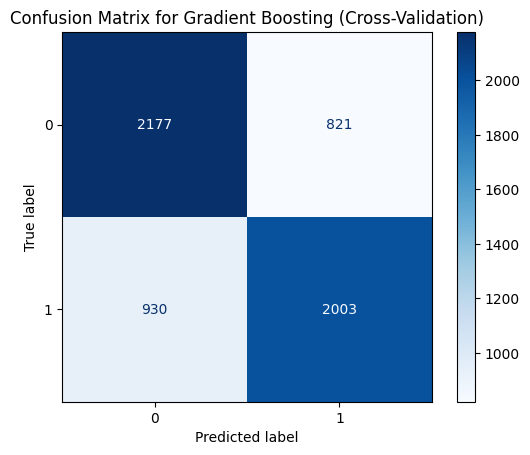

In [86]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate cross-validated predictions
cv_predictions_gbc = cross_val_predict(best_gbc, 
                                       X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], 
                                       y_test, 
                                       cv=5)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, cv_predictions_gbc)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_gbc.classes_)
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix for Gradient Boosting (Cross-Validation)")

# Generate classification report
print("Gradient Boosting with Optimal Parameters Classification Report (Cross Validated):\n")
print(classification_report(y_test, cv_predictions_gbc, target_names=["Decreasing (0)", "Increasing (1)"]))

Comparing with and without HMM feature

In [75]:
#Without 'hidden_state' feature

#2. Random Forest Classifier
rf_bl = RandomForestClassifier(random_state=42)
rf_bl.fit(X_test_df[['normalized_price', 'MA', 'bedrooms']], y_test)
baseline_knn_predictions = rf_bl.predict(X_test_df[['normalized_price', 'MA', 'bedrooms']])

# --- 3. K-Nearest Neighbors (KNN) ---
from sklearn.neighbors import KNeighborsClassifier
knn_bl = KNeighborsClassifier()
knn_bl.fit(X_test_df[['normalized_price', 'MA', 'bedrooms']], y_test)
baseline_knn_predictions = knn_bl.predict(X_test_df[['normalized_price', 'MA', 'bedrooms']])

# --- 4. Decision Tree ---
from sklearn.tree import DecisionTreeClassifier
dtree_bl = DecisionTreeClassifier(random_state=42)
dtree_bl.fit(X_test_df[['normalized_price', 'MA', 'bedrooms']], y_test)
baseline_dtree_predictions = dtree_bl.predict(X_test_df[['normalized_price', 'MA', 'bedrooms']])

# --- 5. Gradient Boosting ---
from sklearn.ensemble import GradientBoostingClassifier
gbc_bl = GradientBoostingClassifier(random_state=42)
gbc_bl.fit(X_test_df[['normalized_price', 'MA', 'bedrooms']], y_test)
baseline_gbc_predictions = gbc_bl.predict(X_test_df[['normalized_price', 'MA', 'bedrooms']])

print(classification_report(y_test, baseline_gbc_predictions))



              precision    recall  f1-score   support

           0       0.70      0.73      0.72      2998
           1       0.71      0.68      0.70      2933

    accuracy                           0.71      5931
   macro avg       0.71      0.71      0.71      5931
weighted avg       0.71      0.71      0.71      5931



In [76]:
#With 'hidden_state' feature

# --- 3. K-Nearest Neighbors (KNN) ---
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test)
knn_predictions = knn.predict(X_test_df[['normalized_price', 'MA', 'bedrooms','hidden_state']])

# --- 4. Decision Tree ---
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_test_df[['normalized_price', 'MA','bedrooms', 'hidden_state']], y_test)
dtree_predictions = dtree.predict(X_test_df[['normalized_price', 'MA','bedrooms', 'hidden_state']])

# --- 5. Gradient Boosting ---
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_test_df[['normalized_price', 'MA', 'bedrooms','hidden_state']], y_test)
gbc_predictions = gbc.predict(X_test_df[['normalized_price', 'MA', 'bedrooms','hidden_state']])

In [77]:
def plot_roc_curve_binary(y_true, y_proba, title):
    """
    Plots the ROC curve for binary classification predictions.

    Parameters:
    - y_true: Array-like, true labels (binary)
    - y_proba: Array-like, predicted probabilities for the positive class

    Output:
    - Displays the ROC curve with AUC score.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    plt.title(title, fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid()
    plt.show()


ROC Curve Comparison

1. Random Forest Classifier Metrics

Random Forest Metrics:
Cross Validated Mean test accuracy: 0.6581
Cross Validated Mean test AUC: 0.7180


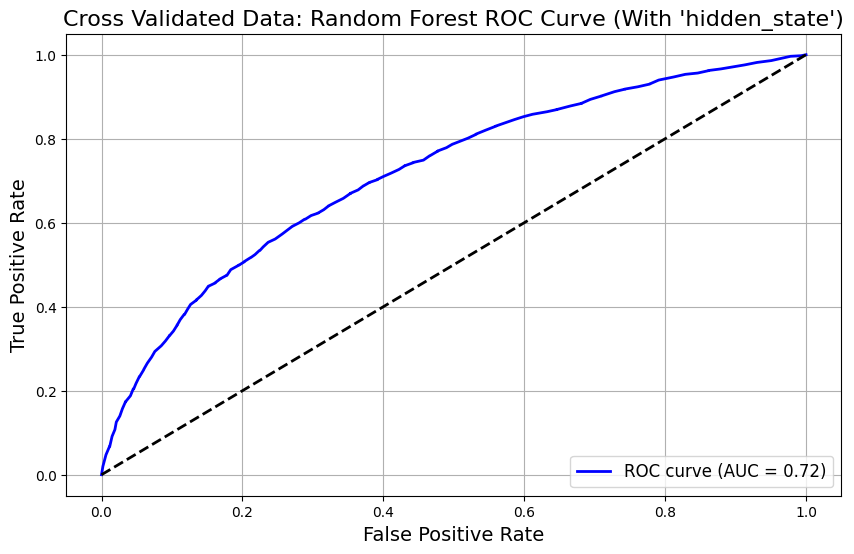

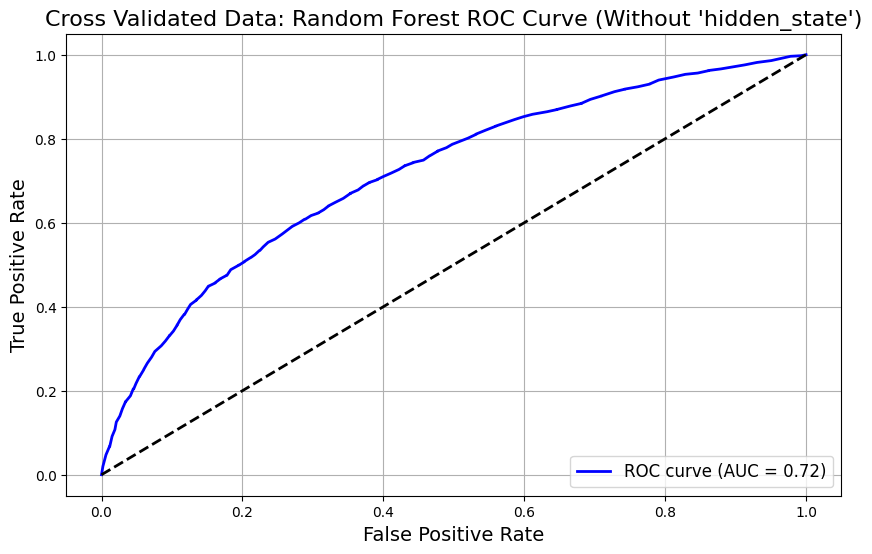

In [78]:
from sklearn.model_selection import cross_val_predict
#Random Forest ROC Curve
# For the ROC curve with the RF model without hidden states without CV
'''rf_probabilities_bl = rf_bl.predict_proba(X_test_df[['normalized_price', 'MA', 'bedrooms']])[:, 1]
plot_roc_curve_binary(y_test, rf_probabilities_bl, title="Random Forest ROC Curve (Without 'hidden_state')")

# For the ROC curve with the RF model with hidden states without CV
rf_probabilities_hmm = rf.predict_proba(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])[:, 1]
plot_roc_curve_binary(y_test, rf_probabilities_hmm, title="Random Forest ROC Curve (With 'hidden_state' as a Feature)")'''

print("Random Forest Metrics:")
print(f"Cross Validated Mean test accuracy: {cv_results_rf['test_accuracy'].mean():.4f}")
print(f"Cross Validated Mean test AUC: {cv_results_rf['test_roc_auc'].mean():.4f}")

rf_probabilities_cv = cross_val_predict(rf, X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test, cv=5, method='predict_proba')[:, 1]
rf_probabilities_cv_bl = cross_val_predict(rf_bl, X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test, cv=5, method='predict_proba')[:, 1]

plot_roc_curve_binary(y_test, rf_probabilities_cv, title="Cross Validated Data: Random Forest ROC Curve (With 'hidden_state')")
plot_roc_curve_binary(y_test, rf_probabilities_cv_bl, title="Cross Validated Data: Random Forest ROC Curve (Without 'hidden_state')")


2. KNN Classifier Metrics

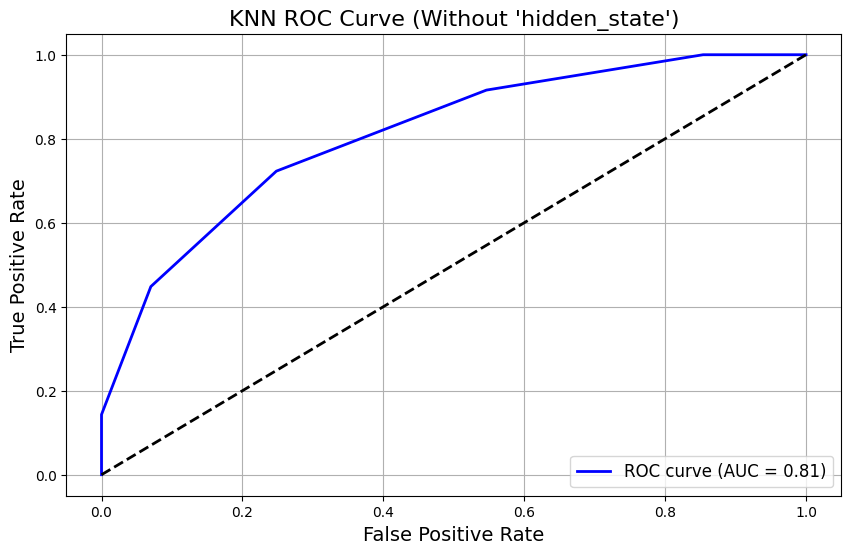

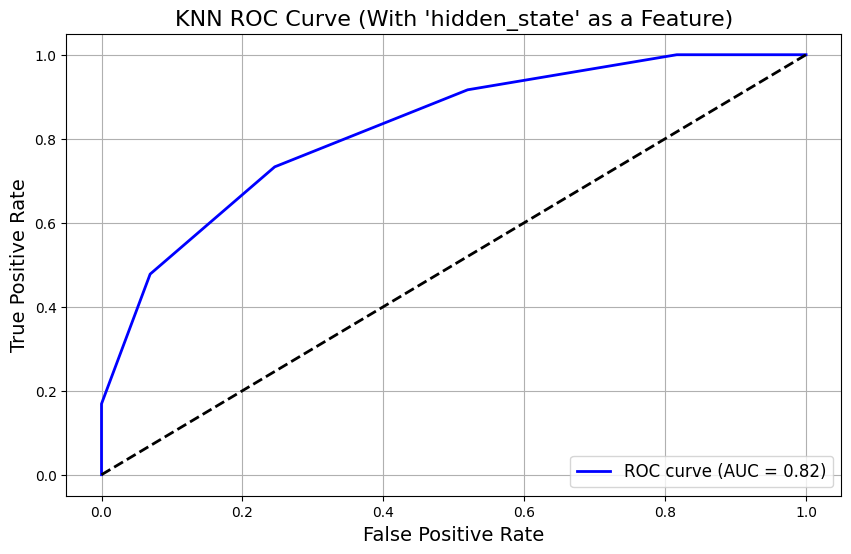

KNN Metrics:
Cross Validated Mean test accuracy: 0.6368
Cross Validated Mean test AUC: 0.6677


In [79]:
#KNN ROC Curve
# For the ROC curve with the KNN model without hidden states
knn_probabilities_bl = knn_bl.predict_proba(X_test_df[['normalized_price', 'MA', 'bedrooms']])[:, 1]
plot_roc_curve_binary(y_test, knn_probabilities_bl, title="KNN ROC Curve (Without 'hidden_state')")

# For the ROC curve with the KNN model with hidden states
knn_probabilities_hmm = knn.predict_proba(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])[:, 1]
plot_roc_curve_binary(y_test, knn_probabilities_hmm, title="KNN ROC Curve (With 'hidden_state' as a Feature)")

print("KNN Metrics:")
print(f"Cross Validated Mean test accuracy: {cv_results_knn['test_accuracy'].mean():.4f}")
print(f"Cross Validated Mean test AUC: {cv_results_knn['test_roc_auc'].mean():.4f}")


3. Decision Tree Metrics

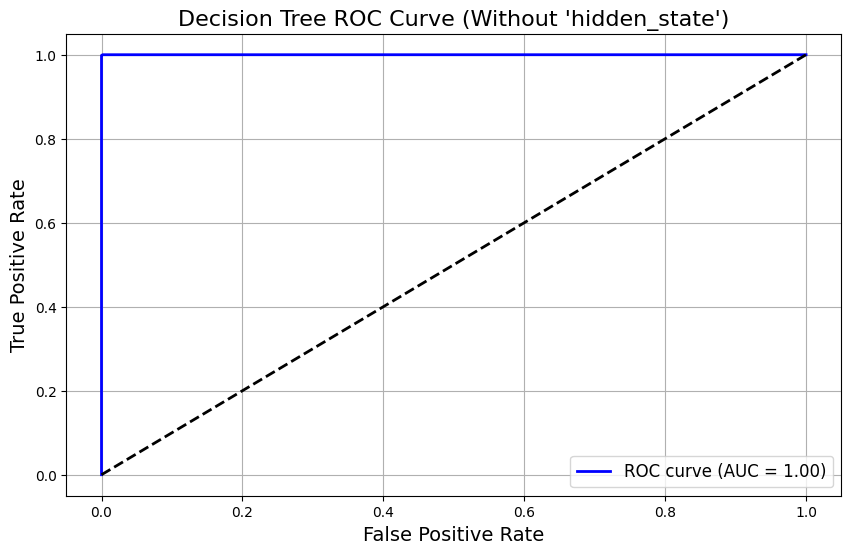

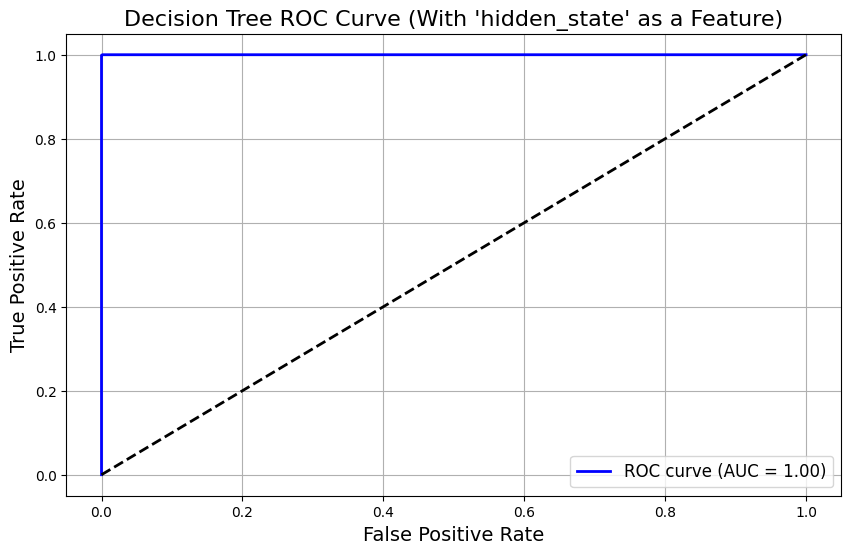

Decision Tree Metrics:


KeyError: 'test_accuracy'

In [80]:
#Decision Tree ROC Curve
# For the ROC curve with the Decision Tree model without hidden states
dtree_probabilities_bl = dtree_bl.predict_proba(X_test_df[['normalized_price', 'MA', 'bedrooms']])[:, 1]
plot_roc_curve_binary(y_test, dtree_probabilities_bl, title="Decision Tree ROC Curve (Without 'hidden_state')")

# For the ROC curve with the KNN model with hidden states
dtree_probabilities_hmm = dtree.predict_proba(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])[:, 1]
plot_roc_curve_binary(y_test, dtree_probabilities_hmm, title="Decision Tree ROC Curve (With 'hidden_state' as a Feature)")

print("Decision Tree Metrics:")
print(f"Cross Validated Mean test accuracy: {cv_results_dtree['test_accuracy'].mean():.4f}")
print(f"Cross Validated Mean test AUC: {cv_results_dtree['test_roc_auc'].mean():.4f}")


4. Gradient Boosting Metrics

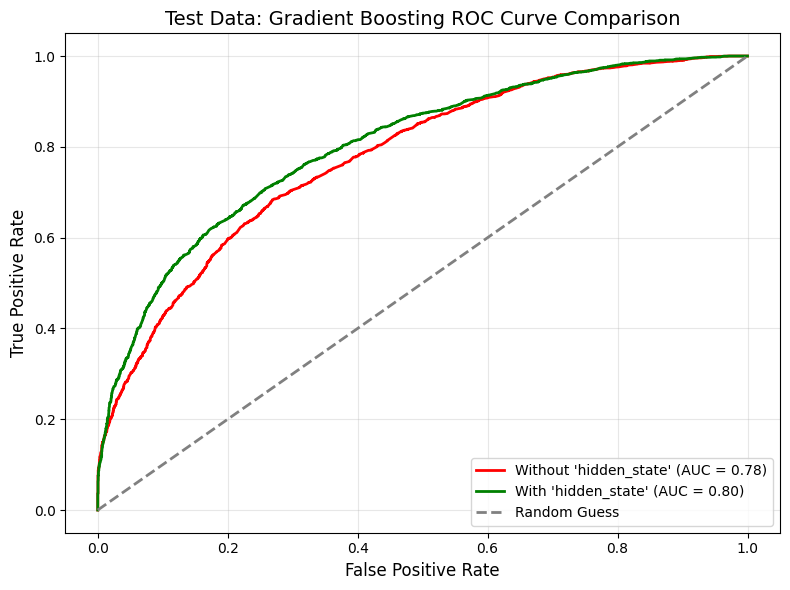

Gradient Boosting Metrics:
Cross Validated Mean test accuracy: 0.7000
Cross Validated Mean test AUC: 0.7679
Grid Search Cross Validated Mean test accuracy: 0.7048
Grid Search Cross Validated Mean test AUC: 0.7694


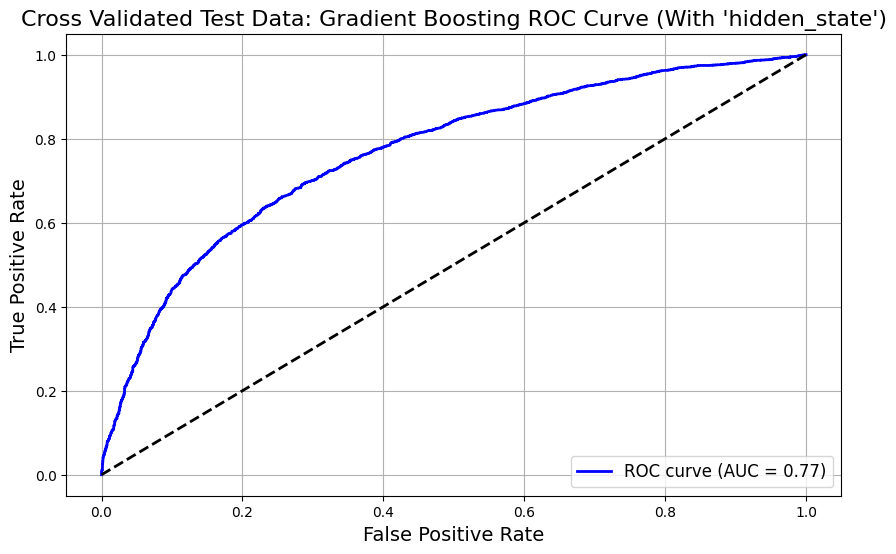

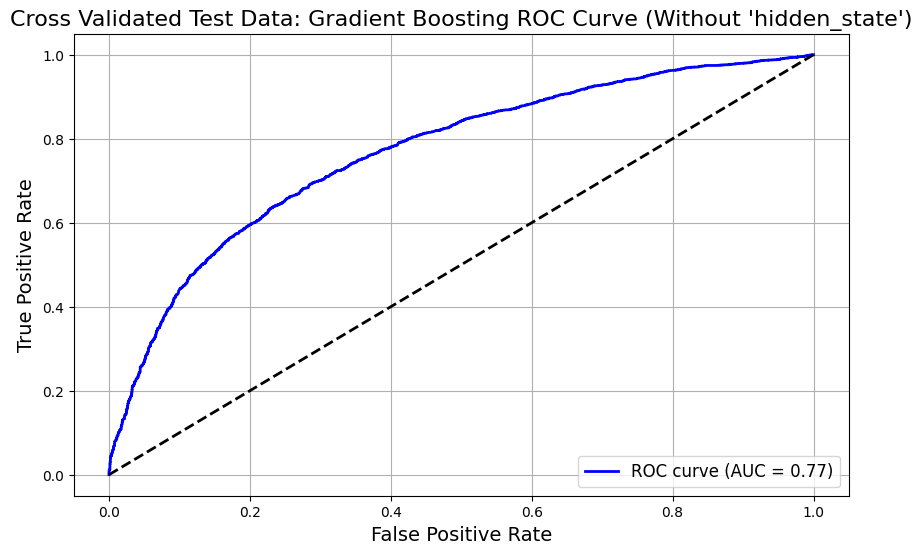

In [ ]:
#Gradient Boosting ROC Curve
# For the ROC curve with the KNN model without hidden states
gbc_probabilities_bl = gbc_bl.predict_proba(X_test_df[['normalized_price', 'MA', 'bedrooms']])[:, 1]

# For the ROC curve with the KNN model with hidden states
gbc_probabilities_hmm = gbc.predict_proba(X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']])[:, 1]

# Calculate FPR, TPR, and AUC for the model without 'hidden_state'
fpr_bl, tpr_bl, _ = roc_curve(y_test, gbc_probabilities_bl)
roc_auc_bl = auc(fpr_bl, tpr_bl)

# Calculate FPR, TPR, and AUC for the model with 'hidden_state'
fpr_hmm, tpr_hmm, _ = roc_curve(y_test, gbc_probabilities_hmm)
roc_auc_hmm = auc(fpr_hmm, tpr_hmm)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_bl, tpr_bl, color='red', lw=2, label=f"Without 'hidden_state' (AUC = {roc_auc_bl:.2f})")
plt.plot(fpr_hmm, tpr_hmm, color='green', lw=2, label=f"With 'hidden_state' (AUC = {roc_auc_hmm:.2f})")

# Plot the diagonal (random guess)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label="Random Guess")

# Add labels, title, and legend
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Test Data: Gradient Boosting ROC Curve Comparison", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

best_cv_results_gbc = cross_validate(best_gbc, X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test, cv=5, scoring=scoring, return_train_score=True)

print("Gradient Boosting Metrics:")
print(f"Cross Validated Mean test accuracy: {cv_results_gbc['test_accuracy'].mean():.4f}")
print(f"Cross Validated Mean test AUC: {cv_results_gbc['test_roc_auc'].mean():.4f}")

print(f"Grid Search Cross Validated Mean test accuracy: {best_cv_results_gbc['test_accuracy'].mean():.4f}")
print(f"Grid Search Cross Validated Mean test AUC: {best_cv_results_gbc['test_roc_auc'].mean():.4f}")

gbc_probabilities_cv = cross_val_predict(gbc, X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test, cv=5, method='predict_proba')[:, 1]
gbc_probabilities_cv_bl = cross_val_predict(gbc_bl, X_test_df[['normalized_price', 'MA', 'bedrooms', 'hidden_state']], y_test, cv=5, method='predict_proba')[:, 1]

plot_roc_curve_binary(y_test, gbc_probabilities_cv, title="Cross Validated Test Data: Gradient Boosting ROC Curve (With 'hidden_state')")
plot_roc_curve_binary(y_test, gbc_probabilities_cv_bl, title="Cross Validated Test Data: Gradient Boosting ROC Curve (Without 'hidden_state')")

AUC = 0.81 without 'hidden_state'
AUC = 0.82 with 'hidden_state' as a feature

Very slight improvement of precision and recall on 0

In [ ]:
print("Model without Hidden States:")
print(classification_report(y_test, baseline_knn_predictions))
print(classification_report(y_test, baseline_dtree_predictions))
print(classification_report(y_test, baseline_gbc_predictions))

Model without Hidden States:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      2998
           1       0.74      0.72      0.73      2933

    accuracy                           0.74      5931
   macro avg       0.74      0.74      0.74      5931
weighted avg       0.74      0.74      0.74      5931

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2998
           1       1.00      1.00      1.00      2933

    accuracy                           1.00      5931
   macro avg       1.00      1.00      1.00      5931
weighted avg       1.00      1.00      1.00      5931

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      2998
           1       0.71      0.68      0.70      2933

    accuracy                           0.71      5931
   macro avg       0.71      0.71      0.71      5931
weighted avg       0.71      0.71      0.71  

In [ ]:
print("Model with Hidden States:")
print(classification_report(y_test, knn_predictions))
print(classification_report(y_test, dtree_predictions))
print(classification_report(y_test, gbc_predictions))

Model with Hidden States:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2998
           1       0.74      0.74      0.74      2933

    accuracy                           0.74      5931
   macro avg       0.74      0.74      0.74      5931
weighted avg       0.74      0.74      0.74      5931

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2998
           1       1.00      1.00      1.00      2933

    accuracy                           1.00      5931
   macro avg       1.00      1.00      1.00      5931
weighted avg       1.00      1.00      1.00      5931

              precision    recall  f1-score   support

           0       0.70      0.75      0.72      2998
           1       0.72      0.67      0.69      2933

    accuracy                           0.71      5931
   macro avg       0.71      0.71      0.71      5931
weighted avg       0.71      0.71      0.71     

Plot Confusion Matrices

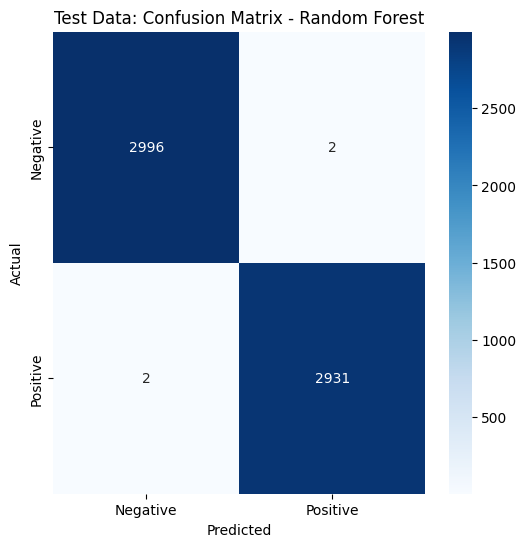

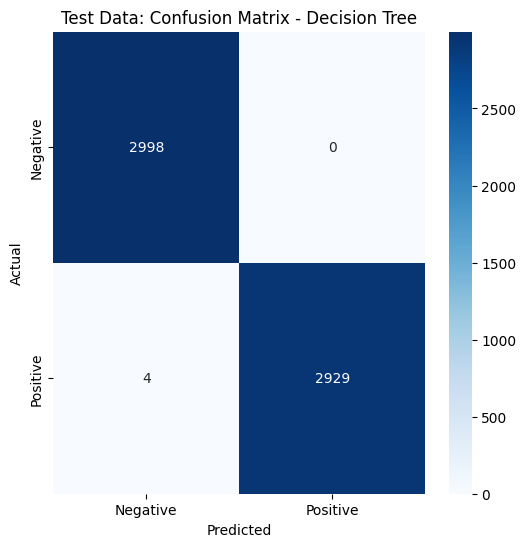

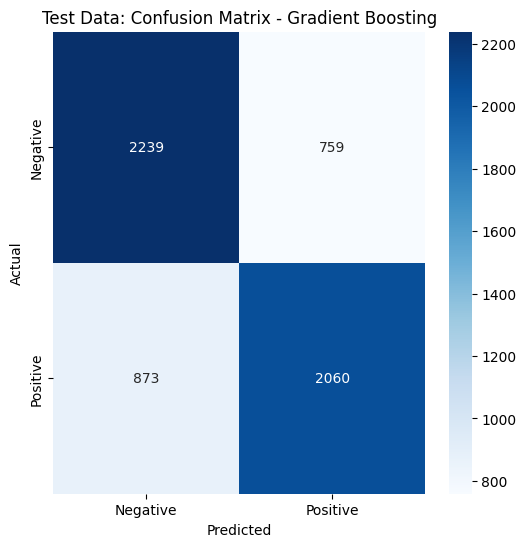

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, predictions, model_name="Model"):
    """
    This function fits a classifier model, predicts the target values on the test set,
    and plots a confusion matrix.

    Parameters:
    - model: Classifier model to train and predict
    - X_test: Test features
    - y_test: True labels for test data
    - features: List of feature names used for the model
    - model_name: Name of the model to display in the plot title
    """

    # Generate confusion matrix
    cm = confusion_matrix(y_test, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f"Test Data: Confusion Matrix - {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


# Call the function for each model
plot_confusion_matrix(y_test, rf_predictions, model_name="Random Forest")
plot_confusion_matrix(y_test, dtree_predictions, model_name="Decision Tree")
plot_confusion_matrix(y_test, gbc_predictions, model_name="Gradient Boosting")
